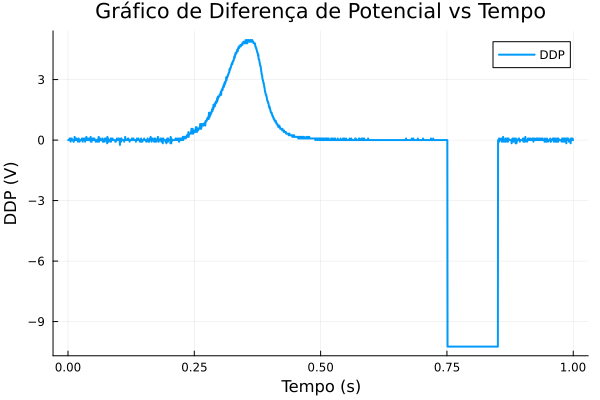

In [1]:
using Plots
using CSV
using DataFrames

dados = CSV.read("dados/ALL0002/F0002CH1.CSV", DataFrame)

tempo = dados[!, 4]
voltagem = dados[!, 5]

plot(tempo, voltagem, label="DDP", xlabel="Tempo (s)", ylabel="DDP (V)", title="Gráfico de Diferença de Potencial vs Tempo", legend=:topright, grid=true, linewidth=2)

In [2]:
function trapezio(x, y, x0, xN, y_min)
    mask = (x .>= x0) .& (x .<= xN) .& (y .>= y_min)
    if sum(mask) < 3
        return 0.0
    end

    xf = x[mask]
    yf = y[mask]
    dx = xf[2] - xf[1]
    integral = (yf[1] + yf[end]) * dx / 2
    integral += sum(yf[2:end-1]) * dx
    return integral
end

for (root, _, files) in walkdir("dados")
    for f in files 
        if endswith(f, ".CSV")
            path = joinpath(root, f)
            df   = CSV.read(path, DataFrame)
            t    = df[!, 4]
            v    = df[!, 5]
            I    = trapezio(t, v, 0, 1, -1)
            println(#= "[$(basename(root))/$(f)]:  =# "Integral = $(round(I, digits=4))")
        end
    end
end

Integral = 0.4777
Integral = 0.4797
Integral = 0.4811
Integral = 0.4802
Integral = 0.4787
Integral = 0.4776
Integral = 0.4789
Integral = 0.4794
Integral = 0.4816
Integral = 0.4773
Integral = 0.4738
Integral = 0.4786
Integral = 0.4799
Integral = 0.48


In [79]:
using Interpolations, QuadGK

x0, xN, y_min = 0, 1, 0.2

for (root, _, files) in walkdir("dados")
    for f in files
        if endswith(f, ".CSV")
            path = joinpath(root, f)
            df   = CSV.read(path, DataFrame)
            t    = df[!, 4]
            v    = df[!, 5]

            itp = LinearInterpolation(t, v; extrapolation_bc=0)

            f_int(x) = (val = itp(x); val >= y_min ? val : 0)
            I, err = quadgk(f_int, x0, xN)

            println("[$(basename(root))/$(f)]: Integral = $(round(I, digits=4)) ± $(round(err, digits=11))")
        end
    end
end

[ALL0002/F0002CH1.CSV]: Integral = 0.4676 ± 6.93e-9
[ALL0003/F0003CH1.CSV]: Integral = 0.4694 ± 6.96e-9
[ALL0004/F0004CH1.CSV]: Integral = 0.4715 ± 6.98e-9
[ALL0005/F0005CH1.CSV]: Integral = 0.4726 ± 7.01e-9
[ALL0006/F0006CH1.CSV]: Integral = 0.4692 ± 6.97e-9
[ALL0007/F0007CH1.CSV]: Integral = 0.4656 ± 6.94e-9
[ALL0008/F0008CH1.CSV]: Integral = 0.4676 ± 6.96e-9
[ALL0009/F0009CH1.CSV]: Integral = 0.4704 ± 7.0e-9
[ALL0010/F0010CH1.CSV]: Integral = 0.4706 ± 6.98e-9
[ALL0011/F0011CH1.CSV]: Integral = 0.4638 ± 6.91e-9
[ALL0012/F0012CH1.CSV]: Integral = 0.4656 ± 6.93e-9
[ALL0013/F0013CH1.CSV]: Integral = 0.4692 ± 6.96e-9
[ALL0014/F0014CH1.CSV]: Integral = 0.4722 ± 7.02e-9
[ALL0016/F0016CH1.CSV]: Integral = 0.4714 ± 7.02e-9
